In [15]:
import pandas as pd
# filter warnings
import warnings
warnings.filterwarnings("ignore")

In [16]:
df = pd.read_csv(r'D:\predictive maintenence\data\ai4i2020.csv')
df.head(2)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0


In [17]:
df = df.drop(columns=['UDI', 'Product ID'])

# Rename columns
df = df.rename(columns={
    'Type': 'type',
    'Air temperature [K]': 'air_temp',
    'Process temperature [K]': 'process_temp',
    'Rotational speed [rpm]': 'rot_speed',
    'Torque [Nm]': 'torque',
    'Tool wear [min]': 'tool_wear',
    'Machine failure': 'machine_failure',
    'TWF': 'twf',
    'HDF': 'hdf',
    'PWF': 'pwf',
    'OSF': 'osf',
    'RNF': 'rnf',
    'failure_mode_count': 'failure_mode_count'
})

df.head()

,type,air_temp,process_temp,rot_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [18]:
df.columns

Index(['type', 'air_temp', 'process_temp', 'rot_speed', 'torque', 'tool_wear',
       'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf'],
      dtype='object')

In [19]:
df['temp_diff'] = df['process_temp'] - df['air_temp']

In [20]:
epsilon = 1e-6
df['heating_risk'] = 1 / ((df['temp_diff'] + epsilon) * (df['rot_speed'] + epsilon))
# Rescale heating_risk
df['heating_risk_scaled'] = df['heating_risk'] * 1e5
df.drop(columns=['heating_risk'], inplace=True)

In [21]:
df['power'] = df['torque'] * df['rot_speed'] * 0.10472

In [22]:
# encode type column with mapping {L:2, M:3, H:5}
df['type'] = df['type'].map({'L': 2, 'M': 3, 'H': 5})

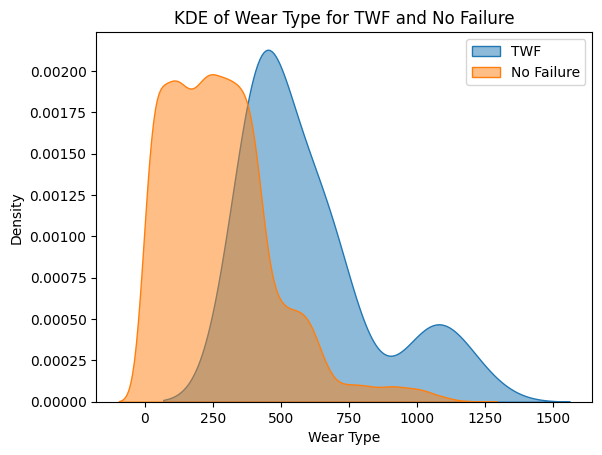

In [23]:
# Make a new feature wear_type which is the product of type and tool_wear
df['wear_type'] = df['type'] * df['tool_wear']

# Plot kde of wear_type for twf and no failure of any type
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(data=df[df['twf'] == 1], x='wear_type', label='TWF', fill=True, alpha=0.5)
sns.kdeplot(data=df[df['machine_failure'] == 0], x='wear_type', label='No Failure', fill=True, alpha=0.5)
plt.title('KDE of Wear Type for TWF and No Failure')
plt.xlabel('Wear Type')
plt.ylabel('Density')
plt.legend()
plt.show()

In [24]:
df['wear_z'] = (df['tool_wear'] - df.groupby('type')['tool_wear'].transform('mean')) \
               / df.groupby('type')['tool_wear'].transform('std')
df.columns

Index(['type', 'air_temp', 'process_temp', 'rot_speed', 'torque', 'tool_wear',
       'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf', 'temp_diff',
       'heating_risk_scaled', 'power', 'wear_type', 'wear_z'],
      dtype='object')

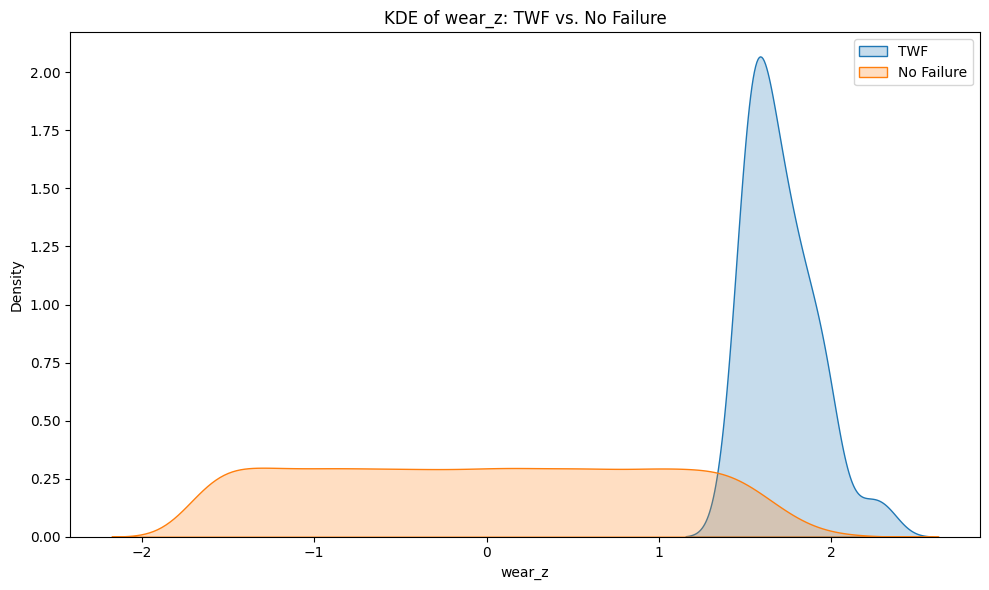

In [25]:


# 2. Filter for TWF vs. “no failure”
df_twf = df[df['twf'] == 1]
df_no  = df[df['machine_failure'] == 0]

# 3. Plot the KDEs for the feature (e.g. wear_z)
plt.figure(figsize=(10, 6))
sns.kdeplot(df_twf['wear_z'], label='TWF', shade=True)
sns.kdeplot(df_no ['wear_z'], label='No Failure', shade=True)

# 4. Tidy up
plt.title('KDE of wear_z: TWF vs. No Failure')
plt.xlabel('wear_z')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
df.columns

Index(['type', 'air_temp', 'process_temp', 'rot_speed', 'torque', 'tool_wear',
       'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf', 'temp_diff',
       'heating_risk_scaled', 'power', 'wear_type', 'wear_z'],
      dtype='object')

In [27]:
# drop air_temp 
df.drop(columns=['air_temp'], inplace=True)

In [28]:
# drop wear_type
df.drop(columns=['wear_type'], inplace=True)

In [30]:
df.columns

Index(['type', 'process_temp', 'rot_speed', 'torque', 'tool_wear',
       'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf', 'temp_diff',
       'heating_risk_scaled', 'power', 'wear_z'],
      dtype='object')

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve, classification_report

# 1. Load your DataFrame
# df = pd.read_csv('your_data.csv')
# ————— replace the above with your actual data-loading step

# 2. Define features & targets
FEATURES = [
    'type', 'process_temp', 'rot_speed', 'torque', 'tool_wear',
    'temp_diff', 'heating_risk_scaled', 'power', 'wear_z'
]
TARGET_ANY = 'machine_failure'
MODE_COLS = ['twf', 'hdf', 'pwf', 'osf', 'rnf']

X = df[FEATURES]
y_any = df[TARGET_ANY]

# 3. First split: train+val vs. test
X_trainval, X_test, y_trainval, y_test_any = train_test_split(
    X, y_any, stratify=y_any, test_size=0.2, random_state=42
)

# 4. Second split: train vs. validation (for threshold calibration)
X_train, X_val, y_train_any, y_val_any = train_test_split(
    X_trainval, y_trainval, stratify=y_trainval, test_size=0.25, random_state=42
)
# Now: 60% train, 20% val, 20% test

# 5. Train Stage-1 “any-failure” filter on TRAIN
clf1 = LGBMClassifier(
    objective='binary',
    scale_pos_weight=(len(y_train_any) - y_train_any.sum()) / y_train_any.sum(),
    random_state=42,verbose=-1
)
clf1.fit(X_train, y_train_any)

# 6. Calibrate τ1 on VALIDATION to hit desired recall
probas_val = clf1.predict_proba(X_val)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val_any, probas_val)

desired_recall = 0.98
# consider recalls[1:]/precisions[1:]/thresholds
valid_idxs = np.where(recalls[1:] >= desired_recall)[0]
if valid_idxs.size > 0:
    # pick the highest threshold that still meets recall ≥ desired_recall
    best_i = valid_idxs[-1]  
    tau1 = thresholds[best_i]
    rec_val = recalls[best_i+1]
    prec_val = precisions[best_i+1]
    print(f"Calibrated τ1 = {tau1:.4f} → recall={rec_val:.3f}, precision={prec_val:.3f} on VAL")
else:
    tau1 = 0.5
    print("Could not hit desired recall on VAL; falling back to τ1 = 0.5")

# 7. Evaluate Stage-1 on TRAIN, VAL, and TEST
def eval_stage1(X_sub, y_sub, split_name):
    y_pred = (clf1.predict_proba(X_sub)[:,1] > tau1).astype(int)
    print(f"\n=== Stage-1 Any-Failure Filter – {split_name} ===")
    print(classification_report(
        y_sub, y_pred, target_names=['Healthy','AnyFailure']
    ))
    
eval_stage1(X_train, y_train_any, 'TRAIN')
eval_stage1(X_val,   y_val_any,   'VALIDATION')
eval_stage1(X_test,  y_test_any,  'TEST')

# 8. Filter rows for Stage-2 based on τ1
mask_trainval = (clf1.predict_proba(X_trainval)[:,1] > tau1)
mask_test     = (clf1.predict_proba(X_test)    [:,1] > tau1)

X2_trainval = X_trainval[mask_trainval]
X2_test     = X_test[mask_test]

y2_trainval = df.loc[X2_trainval.index, MODE_COLS]
y2_test     = df.loc[X2_test.index,     MODE_COLS]

# 9. Stage-2: one-vs-all classification for each failure mode
for mode in MODE_COLS:
    clf_mode = LGBMClassifier(objective='binary', random_state=42)
    clf_mode.fit(X2_trainval, y2_trainval[mode])
    y2_pred = clf_mode.predict(X2_test)
    
    print(f"\n=== Stage-2 {mode.upper()} Classification on Filtered TEST ===")
    print(classification_report(
        y2_test[mode], y2_pred, target_names=[f'not_{mode}', mode]
    ))


Calibrated τ1 = 0.0005 → recall=0.985, precision=0.191 on VAL

=== Stage-1 Any-Failure Filter – TRAIN ===
              precision    recall  f1-score   support

     Healthy       1.00      0.88      0.94      5797
  AnyFailure       0.22      1.00      0.36       203

    accuracy                           0.88      6000
   macro avg       0.61      0.94      0.65      6000
weighted avg       0.97      0.88      0.92      6000


=== Stage-1 Any-Failure Filter – VALIDATION ===
              precision    recall  f1-score   support

     Healthy       1.00      0.85      0.92      1932
  AnyFailure       0.19      0.99      0.32        68

    accuracy                           0.86      2000
   macro avg       0.60      0.92      0.62      2000
weighted avg       0.97      0.86      0.90      2000


=== Stage-1 Any-Failure Filter – TEST ===
              precision    recall  f1-score   support

     Healthy       1.00      0.88      0.93      1932
  AnyFailure       0.21      0.94      

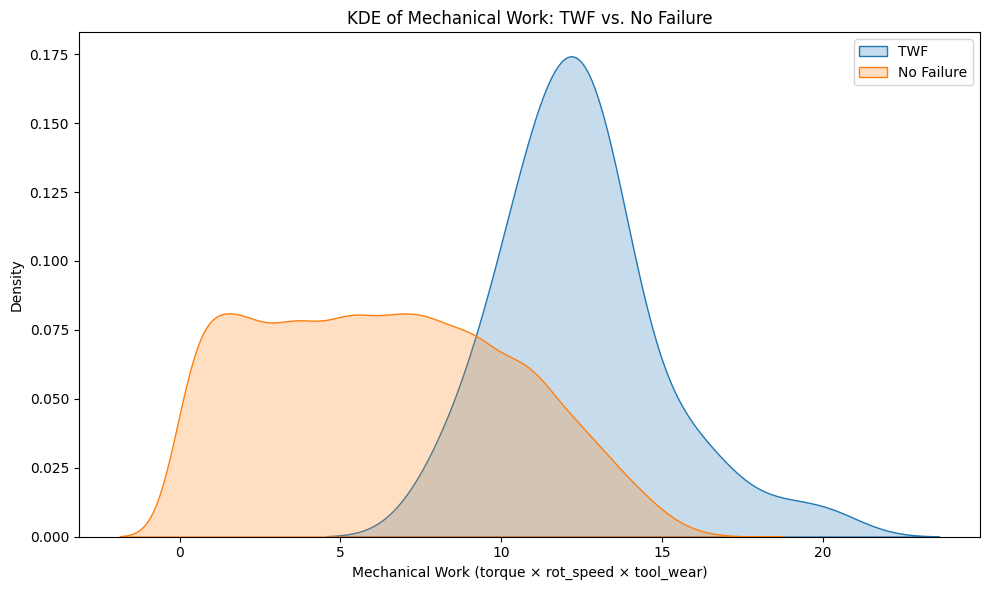

In [45]:
# 1. Create the mechanical_work feature
df['mechanical_work'] = (df['torque'] * df['rot_speed'] * df['tool_wear'])/1000000

# 2. Filter for TWF vs. no failure
df_twf = df[df['twf'] == 1]
df_no  = df[df['machine_failure'] == 0]

# 3. Plot the KDEs
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(df_twf['mechanical_work'], shade=True, label='TWF')
sns.kdeplot(df_no ['mechanical_work'], shade=True, label='No Failure')

plt.title('KDE of Mechanical Work: TWF vs. No Failure')
plt.xlabel('Mechanical Work (torque × rot_speed × tool_wear)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
df.columns

Index(['type', 'process_temp', 'rot_speed', 'torque', 'tool_wear',
       'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf', 'temp_diff',
       'heating_risk_scaled', 'power', 'wear_z', 'mechanical_work'],
      dtype='object')

In [47]:
# save the final DataFrame to a CSV file
df.to_csv(r'D:\predictive maintenence\data\ai4i2020_final.csv', index=False)